<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_SGD_Fitting__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting an HMM using Stochastic Gradient Descent

The parameters $\boldsymbol\theta=(A, B, \pi)$ of an HMM are fitted by maximizing the log-likelihood:
<br><br>
\begin{align*}
\log \Pr(\mathbf y_{1}\cdots, \mathbf y_N|\boldsymbol \theta) = \sum_{n=1}^N\log \Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)
\end{align*}
<br><br>
This is simply the normalizing constant used in the Forwards step of an HMM state inference (see [HMM Inference](https://colab.research.google.com/drive/12JfQRmJOgHXOE1j-gXjfSDHlODpp3RVE?usp=sharing)). Since for every filtered posterior from $1\cdots N$:
<br><br>
\begin{align*}
\boldsymbol\alpha_t&= \Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{t}, \boldsymbol\theta\\
&=\frac{\Pr(\mathbf z_t, \mathbf y_{1}\cdots \mathbf y_{t}|\boldsymbol\theta)}{\Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)}
\end{align*}

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## HMM Inference TensorFlow Module

In [78]:
class HMM_Inference_TFM(tf.Module):
  def __init__(self, transition_matrix, emission_distribution, emission_params, states_probs_0, **kwargs):
    super().__init__(**kwargs)
    constrain_positive = tfp.bijectors.Shift(np.finfo(np.float64).tiny)(tfp.bijectors.Exp())
    self.transition_matrix = tfp.util.TransformedVariable(transition_matrix, bijector=constrain_positive, dtype=tf.float64, name='transition_matrix')
    self.emission_distribution = emission_distribution
    self.emission_params = tfp.util.TransformedVariable(emission_params, bijector=constrain_positive, dtype=tf.float64, name='emission_params')
    self.states_probs_0 = tfp.util.TransformedVariable(states_probs_0, bijector=constrain_positive, dtype=tf.float64, name='states_probs_0')
    self.num_states = self.transition_matrix.shape[0]

  def __call__(self, observations):
    self.update(observations)
    return self.Forward(observations)
    
  def update(self, observations):
    self.batch_dims = observations.shape[0]
    self.num_steps = observations.shape[1]
    self.transition_matrix.assign(self.transition_matrix / self.normalizing_constant(self.transition_matrix, -1))
    self.emission_params.assign(self.emission_params / self.normalizing_constant(self.emission_params, -1))
    self.states_probs_0.assign(self.states_probs_0 / self.normalizing_constant(self.states_probs_0, -2))

  @tf.function
  def normalizing_constant(self, x, dim):
    return tf.reduce_sum(x, dim, keepdims=True)

  @tf.function
  def Forward_step(self, a_t, i):
    a_t = self.local_evidence[:, i] * (tf.transpose(self.transition_matrix) @ a_t)
    Z_t = self.normalizing_constant(a_t, -2)
    a_t = a_t / Z_t
    return a_t, Z_t

  def Forward(self, observations):
    self.emission_model = self.emission_distribution(self.emission_params)
    self.local_evidence = tf.exp(self.emission_model.log_prob(observations[..., tf.newaxis]))[..., tf.newaxis]
    a_t = self.states_probs_0 * self.local_evidence[:, 0]
    Z = self.normalizing_constant(a_t, -2)
    a = a_t / Z
    for i in range(1, self.num_steps):
      a_t, Z_t = self.Forward_step(a_t, tf.constant(i))
      Z = tf.concat([Z, Z_t], 1)
      a = tf.concat([a, a_t], 2)
    return tf.transpose(a, [0, 2, 1])[..., tf.newaxis], Z

## SGD Loss Function and Training Routine

In [21]:
def HMM_Negative_Log_Likelihood(HMM_Forward):
  _, Z = HMM_Forward
  return -tf.reduce_sum(tf.math.log(Z))

def HMM_SGD(inference_module, observations, optimizer, iterations=1):
  for i in range(iterations):
    with tf.GradientTape() as tape:
      HMM_NLL = HMM_Negative_Log_Likelihood(inference_module(observations))
    grads = tape.gradient(HMM_NLL, inference_module.trainable_variables)
    optimizer.apply_gradients(zip(grads, inference_module.trainable_variables))
    tf.print("Iteration {}:\tNLL = {}".format(i, HMM_NLL))

## HMM Observations Generator Function

In [2]:
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  for i in range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    if i == 0: 
      state = state_t
      obs = obs_t
    else: 
      state = tf.concat([state, state_t], 1)
      obs = tf.concat([obs, obs_t], 1)
  return state, obs

## Example 1. Casino HMM Parameter Learning Using SGD

### Set the ground-truth parameters $(A_g, B_g, \pi_g)$

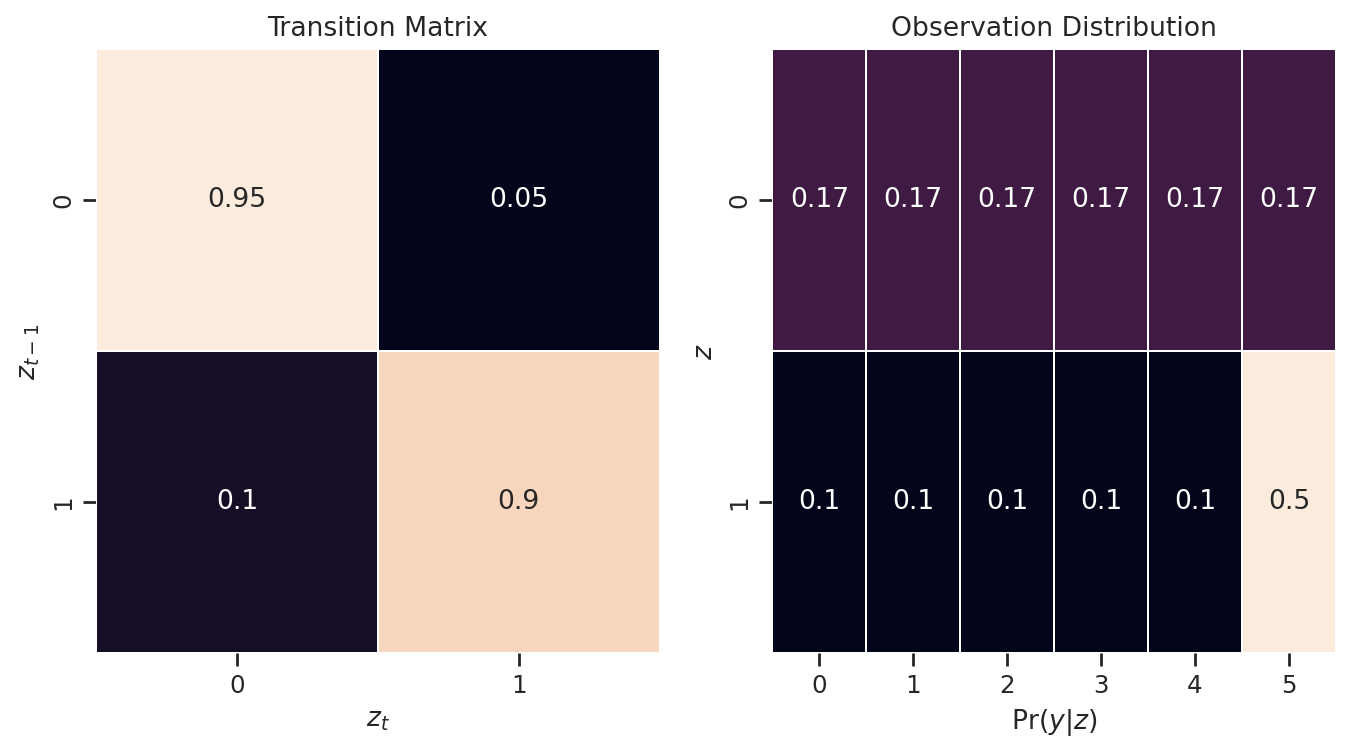

In [3]:
num_states = 2

states_probs_0 = tf.constant([
    [0.5],
    [0.5]
])

transition_matrix = tf.constant([
    [0.95, 0.05], 
    [0.1, 0.9]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution = lambda arg: tfd.Categorical(probs=arg)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(transition_matrix, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(emission_params, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

### Generate Sample Data

In [85]:
num_batches = 5
num_steps = 5000
true_states, observations = HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Generated 5 batches of 5000-step Casino HMM samples 



### Start the training routine

In [ ]:
transition_matrix_init = [[0.5, 0.5], 
                          [0.5, 0.5]]

emission_params_init = [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                        [0.1, 0.2, 0.1, 0.2, 0.1, 0.3]]

emission_distribution = lambda arg: tfd.Categorical(probs=arg)

states_probs_0_init = [[0.5], 
                       [0.5]]

inference_module = HMM_Inference_TFM(transition_matrix_init, emission_distribution, emission_params_init, states_probs_0_init)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.75)
num_iter = 100
HMM_SGD(inference_module, observations, optimizer, iterations=num_iter)


Iteration 0:	NLL = 44189.848599585705
Iteration 1:	NLL = 44189.43267643196
Iteration 2:	NLL = 44190.64456468078
Iteration 3:	NLL = 44191.90302485801
Iteration 4:	NLL = 44193.01833049285
Iteration 5:	NLL = 44193.98133350181
Iteration 6:	NLL = 44194.81064467973
Iteration 7:	NLL = 44195.52649059711
Iteration 8:	NLL = 44196.14616360218
Iteration 9:	NLL = 44196.68376088861
Iteration 10:	NLL = 44197.15072204148
Iteration 11:	NLL = 44197.556404955394
Iteration 12:	NLL = 44197.90855331331
Iteration 13:	NLL = 44198.21365065902
Iteration 14:	NLL = 44198.47718397404
Iteration 15:	NLL = 44198.7038400803
Iteration 16:	NLL = 44198.89765318304
Iteration 17:	NLL = 44199.06211690384
Iteration 18:	NLL = 44199.20027031364
Iteration 19:	NLL = 44199.31476470703
Iteration 20:	NLL = 44199.40791592485
Iteration 21:	NLL = 44199.48174569302
Iteration 22:	NLL = 44199.538014517704
Iteration 23:	NLL = 44199.57824805824
Iteration 24:	NLL = 44199.6037584944
Iteration 25:	NLL = 44199.615662187985
Iteration 26:	NLL = 

### Results

In [ ]:
tf.print('True parameters\n\n{}\n\n{}\n\n{}'.format(transition_matrix, emission_params, states_probs_0), '\n\n')

inference_module.update(observations)
for params in inference_module.variables:
  tf.print(tf.round(tf.exp(params)*1e9)/1e9)